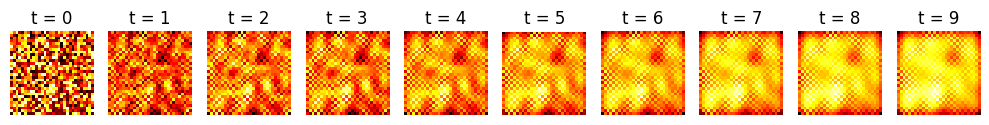

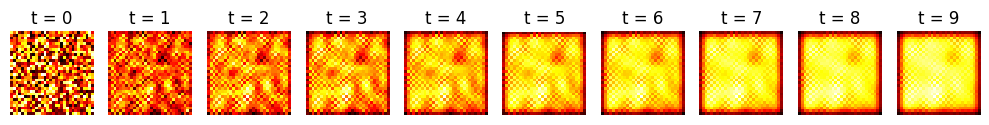

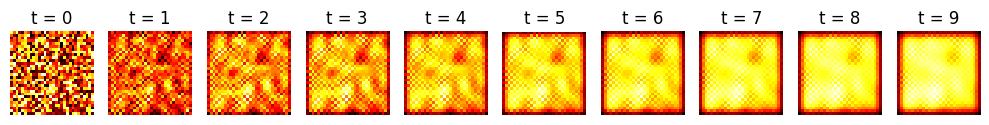

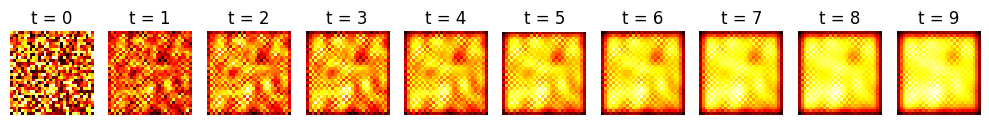

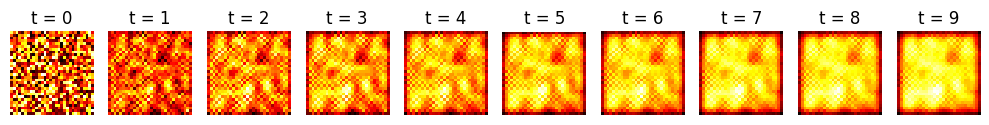

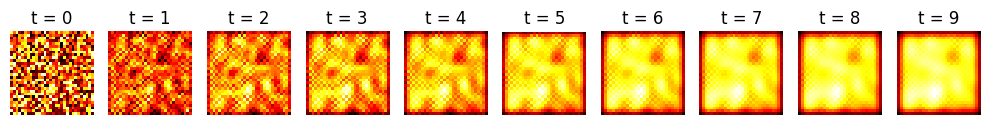

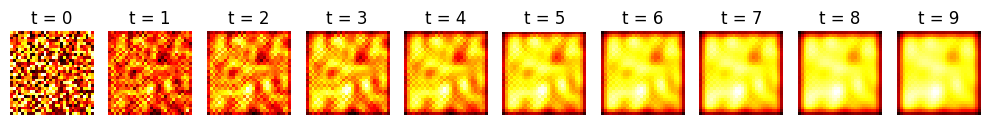

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def initialize_grid(size):
    grid = np.random.rand(size, size)
    return grid

def aggregation_kernel(u,v, eps=.1, method='log'):
    if method == 'log':
        return np.log(np.abs(u-v)+1e-6)
    if method == 'gauss':
        return np.exp(-np.abs(u-v)**2/(4*eps**2))/np.sqrt(4*np.pi*eps**2)

def apply_diffusion1(grid, diffusion_rate1=0.1, diffusion_rate2=0.25, eps=None, method=None, grid0=0):
    kernel = diffusion_rate1 * np.array([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]])
    return grid + convolve(grid, kernel, mode='constant', cval=0.0)


def apply_diffusion2(grid, diffusion_rate1=0.1, diffusion_rate2=0.25, eps=.1, method='log', grid0=0):

    kernel = diffusion_rate1 * np.array([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]])
    grid1 = grid + convolve(grid, kernel, mode='constant', cval=0.0)

    k = lambda u, v: aggregation_kernel(u, v, eps, method)
    
    # 3 x 3
    grid2 = np.zeros_like(grid)
    for i in range(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            grid2[i, j] = diffusion_rate1 * (
                k(grid[i-1, j], grid[i, j]) * grid[i-1, j] + 
                k(grid[i+1, j], grid[i, j]) * grid[i+1, j] + 
                k(grid[i, j-1], grid[i, j]) * grid[i, j-1] + 
                k(grid[i, j+1], grid[i, j]) * grid[i, j+1])

    return grid2 + grid1

def apply_diffusion3(grid, diffusion_rate1=0.25, diffusion_rate2=0.1, eps=.1, method='fisher', grid0=0):

    kernel = diffusion_rate1 * np.array([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]])
    grid1 = grid + convolve(grid, kernel, mode='constant', cval=0.0)
   
    # 1 x 1
    grid2 = np.zeros_like(grid)
    if method == 'fisher':
        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                grid2[i, j] = diffusion_rate2 * ((1-grid[i,j])* grid[i,j])
    elif method == 'allen-cahn':
        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                grid2[i, j] = diffusion_rate2 * ( grid[i,j]*(1-grid[i,j]**2))
    elif method == 'Zeldovich':
        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                grid2[i, j] = diffusion_rate2 * ( grid[i,j]*(grid[i,j]-grid[i,j]**2))
    elif method == 'BS':
        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                grid2[i, j] = diffusion_rate2 * (-(grid[i,j-1]+grid[i,j+1]+grid[i-1,j]+grid[i+1,j]))
    elif method == 'ST':
        grid2 = diffusion_rate2 * grid0
    elif method == 'FB':
        kernel = diffusion_rate2 * np.array([[0, -1, 0],
                                        [-1, 1, -1],
                                        [0, -1, 0]])
        grid2 = convolve(grid, kernel, mode='constant', cval=0.0)
    elif method == 'FB*':
        kernel = diffusion_rate2 * np.array([[0, -1, 0],
                                        [-1, 2,- 1],
                                        [0, -1, 0]])
        grid2 = convolve(grid, kernel, mode='constant', cval=0.0)
    return grid2 + grid1


def plot_grid(grid, time_step, ax):
    ax.imshow(grid, cmap='hot', interpolation='nearest')
    ax.set_title(f"t = {time_step}")
    ax.axis('off')

def main(grid, apply_diffusion, diffusion_rate1, diffusion_rate2, eps=.1 ,method='log'):
    # 初始化参数
    grid0= grid
    num_steps = 10
    s =1
    fig, axs = plt.subplots(1, num_steps//s, figsize=(10, 3))
    
    for step in range(num_steps):
        if step % s == 0:
            plot_grid(grid, step, axs[step//s])    
        grid = apply_diffusion(grid, diffusion_rate1, diffusion_rate2, eps, method, grid0=grid0)
    # print(grid)
    plt.tight_layout()
    plt.show()

grid_size = 30
grid = initialize_grid(grid_size)
diffusion_rate1 = 0.25  # diffusion term
diffusion_rate2 = 0.05   # reaction_term
# main(grid, apply_diffusion1, diffusion_rate)
# main(grid, apply_diffusion2, diffusion_rate)
# main(grid, apply_diffusion2, diffusion_rate, method='gauss')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='BS')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='fisher')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='allen-cahn')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='Zeldovich')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='ST')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='FB')
main(grid, apply_diffusion3, diffusion_rate1, diffusion_rate2, method='FB*')